# Industry Accelerators - Utilities Customer Micro-Segmentation Prediction Models 


## Introduction


In this notebook we will do some customer micro-segmentation work. Segmentation can help you to identify and understand customer subgroups and how they differ from one another. Customer segmentation has many beneficial uses. In our case for example, the aim is to build micro-segmentations that cluster customers based on their behaviours related to lifestyle and engagement. The input for this model includes customer demographic details, survey based questionnaire features relating to *lifestyle, sustainability, historical energy usage and Cost-to-Serve* the customers. 

In the first section of the notebook we read in the raw data, do some data preparation and build segments based on customer's lifestyle. In the next section of the notebook we use the customer's historical energy usage and Cost-to-Serve to segment the customers into different groups.  

We will go through the end-to-end process of importing raw data, preparing the data, building the segmentations and deploying the models. 

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM.<br>
© Copyright IBM Corp. 2020. All Rights Reserved.<br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.**

In the cell below we import the python libraries that we will use throughout the notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics

import sys
import seaborn as sns
sns.set(style='darkgrid',palette="deep")

from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree

# use this library for reading and saving data in CP4D
from project_lib import Project
project = Project()

## Functions

The functions below are used to plot the distribution of categorical and numerical variables by each cluster.

In [2]:
def plot_categorical_vars(cat_var_for_plotting, prepped_data_pre_transform,cluster_name):
    df_temp = prepped_data_pre_transform.groupby([cluster_name, cat_var_for_plotting]).size().reset_index()
    df_temp.rename(columns={0:'VALUES'}, inplace=True)
    df_temp = df_temp.pivot(index=cluster_name, columns=cat_var_for_plotting, values='VALUES').reset_index()
    df_temp
    
    ax = df_temp.set_index(cluster_name).plot(kind='bar', stacked=True, figsize=(12,7), title=cat_var_for_plotting + ' by Cluster')
    
    return

In [3]:
def plot_numeric_vars(var, prepped_data_pre_transform, engagement_cluster):
    
    if len(prepped_data_pre_transform[var].unique()) > 2:
    
        plt.figure(figsize=(12,7))
        for cluster in prepped_data_pre_transform[engagement_cluster].unique():
            # Subset to the airline
            subset = prepped_data_pre_transform[prepped_data_pre_transform[engagement_cluster] == cluster]
            try:
                # Draw the density plot
                sns.distplot(subset[var], hist = False, kde = True,
                             kde_kws = {'linewidth': 3},
                             label = 'cluster ' + str(cluster))

                plt.title('Density Plot for ' + var)    
            except:
                pass
    return

## Load Raw Data

For this project we will be loading the csv file called `Customer Micro-Segmentation Input.csv`. The file contains demographic, questionnaire and energy usage details for 1,000 customers. The cells below import the data using the project_lib library and display a sample of the raw data.

In [4]:
my_file = project.get_file('Customer Micro-Segmentation Input.csv')
my_file.seek(0)
df_prep = pd.read_csv(my_file)

df_prep.head()

,CUSTOMER_ID,PROD_ECOLOGICAL,PROD_MEAT_SUBST,PROD_FAIRTRADE,PROD_REFORM,GREEN_ENERGY,FREQUENTING_NATURE,ENVIR_CHARITY,NATURE_CHARITY,AGE_GROUP,INCOME_LEVEL,EDUCATION,TOTAL_USAGE_YEAR1,TOTAL_USAGE_YEAR2,ENERGY_SAVING,COST_TO_SERVE
0,1,1,0,0,0,1,0,0,0,<20,"40,000-55,000",Bachelor's degree or more,5055.71,3979.551562,-21.286000,75.05
1,2,0,0,0,1,1,0,0,0,35 to 39,"55,000-75,000",Bachelor's degree or more,8636.82,7077.181393,-18.058019,145.17
2,3,0,1,0,0,0,1,1,1,>64,"55,000-75,000",Master's degree,11454.37,12733.783970,11.169658,164.59
3,4,0,1,0,0,0,1,0,0,30 to 34,"40,000-55,000",High school graduate,5668.38,5208.521333,-8.112700,144.40
4,5,0,1,1,0,0,0,0,0,30 to 34,"40,000-55,000",High school graduate,7499.15,9032.882231,20.452081,67.64


##  User Inputs & Data Prep

**customer_id_col :** Column indicates customer id. <br>

**survey_cols_to_summarize :** A list of columns representing survey questions for which customers answered yes/no.<br>
**lifestyle_categorical_cols :** A list of all categorical variables that need to be transformed before input into lifestyle clustering model. We will use a transformer to impute missing values and create dummy variables.<br>
**lifestyle_numerical_cols :** A list of all of the numerical features that we input into lifestyle clustering model. We include code that uses a transformer to impute any missing values and standardize these columns. In our example we leave this list empty as we are only using categorical variables.<br>

**energy_usage_cols :** Columns with historical annual total energy usage. <br>
**customer_engagement_categorical_cols :** A list of all categorical variables that need to be transformed before input into Customer Engagement Segmentation model. We will use a transformer to impute missing values and create dummy variables. In our example, this list is empty as we are using only numerical columns.<br>
**customer_engagement_numerical_cols :** A list of all of the numerical features that we input into Customer Engagement Segmentation model. Later in the code, we use a transformer to impute any missing values and standardize these columns.<br>

If the data scientist is using their own data, they can easily update the variables below to point at their own specific column names.

In [5]:
customer_id_col='CUSTOMER_ID'

survey_cols_to_summarize=['PROD_ECOLOGICAL', 'PROD_MEAT_SUBST', 'PROD_FAIRTRADE','PROD_REFORM', 'GREEN_ENERGY', 'FREQUENTING_NATURE', 'ENVIR_CHARITY','NATURE_CHARITY']
lifestyle_categorical_cols=['EDUCATION','INCOME_LEVEL']
lifestyle_numerical_cols=[]

energy_usage_cols=['TOTAL_USAGE_YEAR1', 'TOTAL_USAGE_YEAR2']
customer_engagement_numerical_cols=['ENERGY_SAVING','COST_TO_SERVE']
customer_engagement_categorical_cols=[]

In addition, we create new features based off the existing columns.

**NUMBER_OF_QUESTIONS_ANSWERED_YES :** Total number of lifestyle survey questions answered 'Yes' by a customer.<br>
**NUMBER_OF_QUESTIONS_ANSWERED_YES_CAT :** Since all other variables used in the lifestyle cluster are categorial, we create a new variable which groups the numerical variable created above.<br>
**ENERGY_SAVING :** Percentage change in the energy usage compared to previous year. Lower the percentage indicates the higher energy savings and vice versa.<br>

We also create a dictionary which stores some of the user inputs here. We save the dictionary as part of the metadata when deploying our final models. It gets deployed with the models and can be retrieved in the deployed function, as we will demonstrate in the 2-model_scoring_and_app_deployment notebook.

In [6]:
df_prep['NUMBER_OF_QUESTIONS_ANSWERED_YES']=df_prep[survey_cols_to_summarize].sum(axis=1)

df_prep['NUMBER_OF_QUESTIONS_ANSWERED_CAT'] = 'TWO OR THREE'
df_prep.loc[df_prep['NUMBER_OF_QUESTIONS_ANSWERED_YES']<=1, 'NUMBER_OF_QUESTIONS_ANSWERED_CAT'] = 'ONE OR LESS'
df_prep.loc[df_prep['NUMBER_OF_QUESTIONS_ANSWERED_YES']>=4, 'NUMBER_OF_QUESTIONS_ANSWERED_CAT'] = 'FOUR OR MORE'

# add the variable to list of categorical variables
lifestyle_categorical_cols.append('NUMBER_OF_QUESTIONS_ANSWERED_CAT')

df_prep['ENERGY_SAVING']=df_prep[energy_usage_cols].apply(lambda row: (row.iloc[1]-row.iloc[0])/row.iloc[0]*100, axis=1)

In [7]:
user_inputs_dict = {'customer_id' : customer_id_col, 'survey_cols_to_summarize' : survey_cols_to_summarize, 'energy_usage_cols' : energy_usage_cols}

In [8]:
df_prep.head()

,CUSTOMER_ID,PROD_ECOLOGICAL,PROD_MEAT_SUBST,PROD_FAIRTRADE,PROD_REFORM,GREEN_ENERGY,FREQUENTING_NATURE,ENVIR_CHARITY,NATURE_CHARITY,AGE_GROUP,INCOME_LEVEL,EDUCATION,TOTAL_USAGE_YEAR1,TOTAL_USAGE_YEAR2,ENERGY_SAVING,COST_TO_SERVE,NUMBER_OF_QUESTIONS_ANSWERED_YES,NUMBER_OF_QUESTIONS_ANSWERED_CAT
0,1,1,0,0,0,1,0,0,0,<20,"40,000-55,000",Bachelor's degree or more,5055.71,3979.551562,-21.286000,75.05,2,TWO OR THREE
1,2,0,0,0,1,1,0,0,0,35 to 39,"55,000-75,000",Bachelor's degree or more,8636.82,7077.181393,-18.058019,145.17,2,TWO OR THREE
2,3,0,1,0,0,0,1,1,1,>64,"55,000-75,000",Master's degree,11454.37,12733.783970,11.169658,164.59,4,FOUR OR MORE
3,4,0,1,0,0,0,1,0,0,30 to 34,"40,000-55,000",High school graduate,5668.38,5208.521333,-8.112700,144.40,2,TWO OR THREE
4,5,0,1,1,0,0,0,0,0,30 to 34,"40,000-55,000",High school graduate,7499.15,9032.882231,20.452081,67.64,2,TWO OR THREE


### Build Transformer

We use built-in sklearn transformers to process the data and get it ready for input into the model. 

For categorical variables we create a pipeline with 2 steps. We first use the `SimpleImputer` transformer to fill in missing values with `'Other'`. Next we use `OneHotEncoder` to create dummy variables for each category. 

For numerical variables we again use the `SimpleImputer` transformer to fill in missing values. We also standardize any numerical variables using `MinMaxScaler`.

These transformers are both used in the lifestyle and customer engagement clusters.

In [9]:
categorical_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='Other')), ('dummy_vars', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='mean')), ('standardise_vars', MinMaxScaler())])

## Lifestyle Clustering Model

### Display distribution of categorical columns for Lifestyle Clustering Model

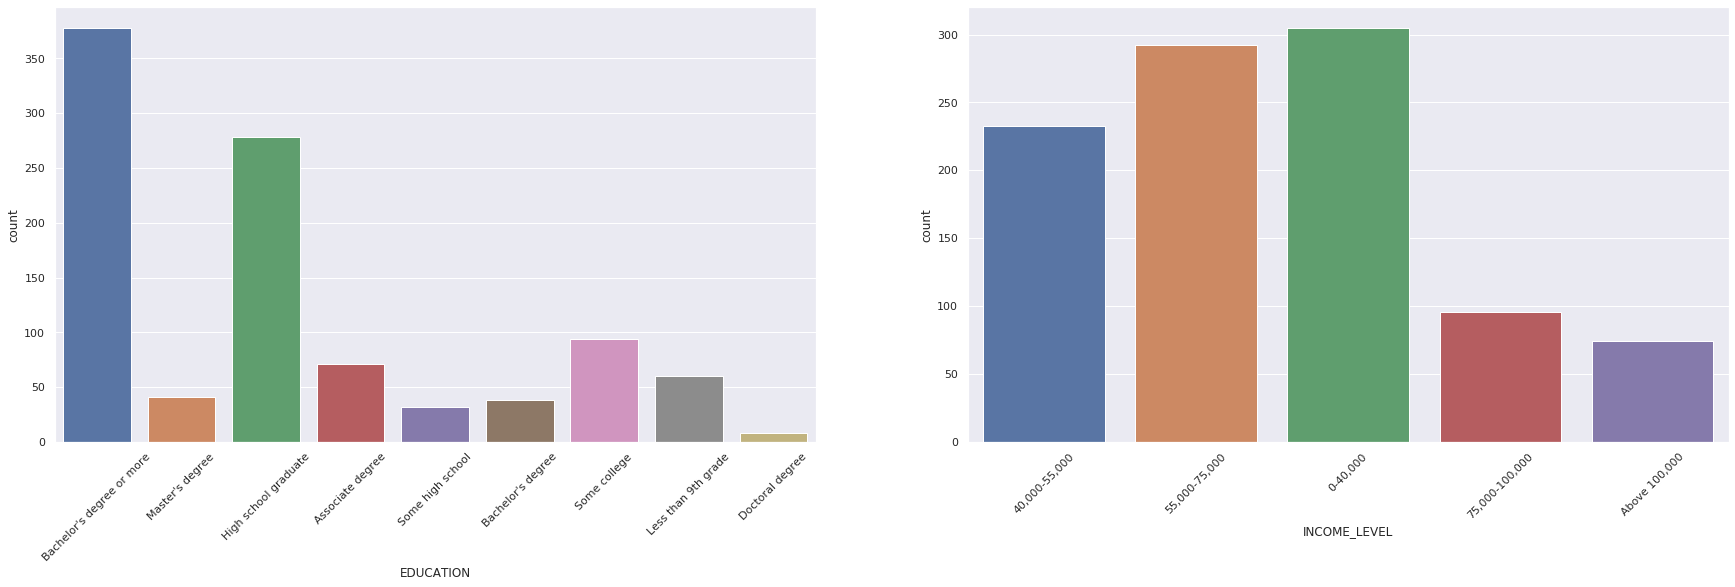

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(30, 8))

for variable, subplot in zip(lifestyle_categorical_cols, ax.flatten()):
    sns.countplot(df_prep[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

### Apply Transformer

We combine the two transformers created in the previous stage and apply them to the features specified in `lifestyle_categorical_cols` and `lifestyle_numerical_cols` lists. In our case, since `lifestyle_numerical_cols` is an empty list, the transformer only created dummy variables for the features listed in the `lifestyle_categorical_cols` list.  

In [11]:
lifestyle_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, lifestyle_numerical_cols),
        ('cat', categorical_transformer, lifestyle_categorical_cols)
            ],sparse_threshold=0)

lifestyle_postprocess = lifestyle_preprocessor.fit_transform(df_prep)

### Clustering

We can now begin clustering our customers. We will use the **Agglomerative Clustering** algorithm for this. We'll loop through the AgglomerativeClustering algorithm using a range of number of clusters and determine the optimal cluster number by using the metric called silhouette coefficient. The silhouette coefficient indicates how similar the observations within its own cluster are compared to other observations in different clusters. Range for silhouette coefficient are from -1 to 1 where 1 represents objects within its own cluster are well paired.

In [12]:
silhouette_scores = []
for i in range(2,9):
    agg = AgglomerativeClustering(n_clusters = i, affinity = 'manhattan', linkage ='complete')
    cluster_assignments = agg.fit_predict(lifestyle_postprocess)
    X=silhouette_score(lifestyle_postprocess,cluster_assignments)
    silhouette_scores.append(X)
    print("CLUSTERS",i,"SCORE",X)

CLUSTERS 2 SCORE 0.3488582992250407
CLUSTERS 3 SCORE 0.4441429255209034
CLUSTERS 4 SCORE 0.3979509875795306
CLUSTERS 5 SCORE 0.36314521294772945
CLUSTERS 6 SCORE 0.35658521153228073
CLUSTERS 7 SCORE 0.37775511730206396
CLUSTERS 8 SCORE 0.42038312862204175


From the above exercise we can see that the silhouette coefficient is high for `n_clusters=3`. Hence we select 3 clusters for the lifestyle clustering model.

We then fit the clustering algorithm to our data using the specified 3 clusters. Then we add those cluster assignments back to the prepped data dataframe so that we can visualize the results.

In [13]:
lifestyle_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'manhattan', linkage ='complete')
y_clusters = lifestyle_cluster.fit_predict(lifestyle_postprocess)
df_prep['LIFESTYLE_CLUSTER'] = y_clusters
df_prep['LIFESTYLE_CLUSTER'] = df_prep['LIFESTYLE_CLUSTER'] + 1

In [14]:
num_clusters = len(df_prep['LIFESTYLE_CLUSTER'].value_counts())
df_prep['LIFESTYLE_CLUSTER'].value_counts()

3    361
1    322
2    317
Name: LIFESTYLE_CLUSTER, dtype: int64

### Plot Variable Distribution by Cluster

The below code loops through each categorical variable and plots the distribution of each variable by cluster.

Taking the example of Cluster 2, we see that the majority of customers are higher paid with at least an Associate Degree. They also answered 'Yes' to more questions in the lifestyle & sustainability survey questionnaire than the customers in the other clusters.

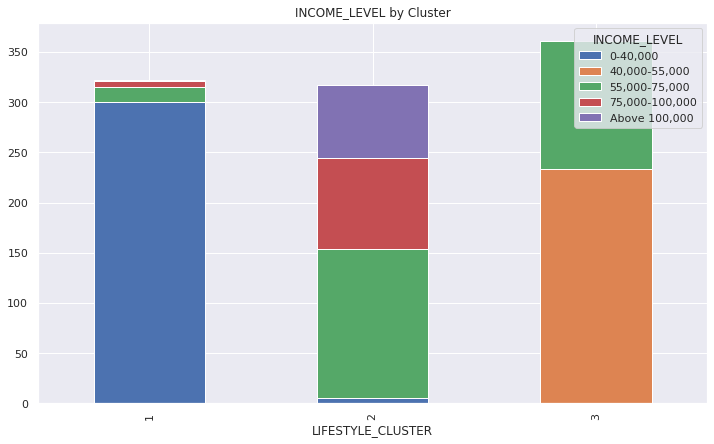

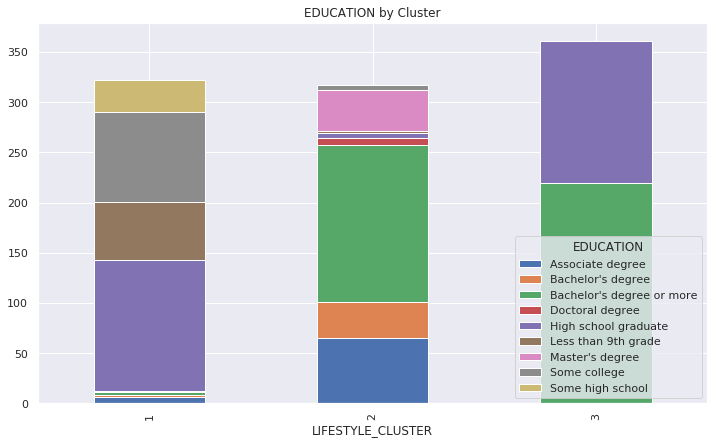

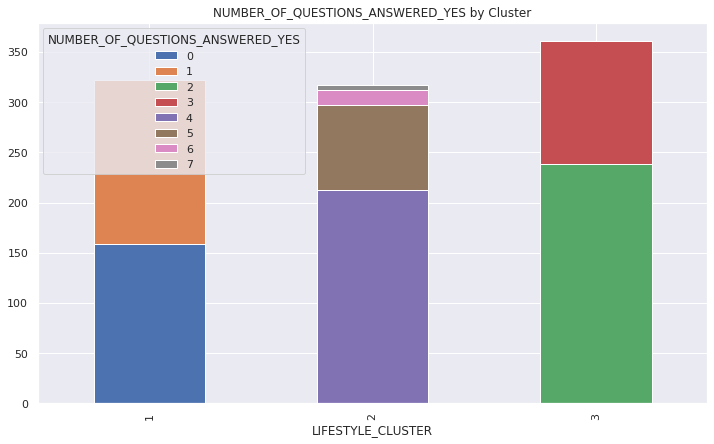

In [15]:
cluster_name='LIFESTYLE_CLUSTER'
for var in ['INCOME_LEVEL', 'EDUCATION', 'NUMBER_OF_QUESTIONS_ANSWERED_YES']:
    plot_categorical_vars(var, df_prep,cluster_name)

All customers are assigned to a cluster based on their Income Level, Education, Number of Questions Answered Yes. We apply the below segment description to each cluster: <br>
<br>
**Cluster 1:** Green Negative <br>
**Cluster 2:** Green Positive <br>
**Cluster 3:** Green Neutral<br>

### Build Classifier Model on Lifestyle Clustering data

We built the lifestyle clustering model using AgglomerativeClustering algorithm. In order to assign new data to the existing clusters we can use a classifier model on top of the hierarchical clustering. For our case we will build a decision tree model.

#### Split Data and Build Pipeline
We split the existing data into training and test sets. We use 75% of the data for training and the remaining 25% for testing.

In [16]:
X = df_prep.drop('LIFESTYLE_CLUSTER', axis=1)
y = df_prep['LIFESTYLE_CLUSTER']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=123)

We use the transformers created earlier in the notebook to process the data and combine them with a decision tree model to create our final pipeline.

With this final pipeline we can pass data in data in its raw form, with missing values and categorical data. The missing data is replaced and dummy variables are created, this prepped data is then passed to the model and the cluster assignments are returned.

In [17]:
lifestyle_pipeline = Pipeline(steps=[('preprocessor', lifestyle_preprocessor),
                      ('classifier', tree.DecisionTreeClassifier())])

lifestyle_clf = lifestyle_pipeline.fit(X_train, y_train)

y_pred_train = lifestyle_clf.predict(X_train)
y_pred_test = lifestyle_clf.predict(X_test)

#### View Model Results

We will look at how accurate the model is at predicting which cluster should be assigned. We also plot the confusion matrix.

In [18]:
train_acc = metrics.accuracy_score(y_train, y_pred_train)
test_acc = metrics.accuracy_score(y_test, y_pred_test)

print("Training Accuracy of " + str(train_acc) + " and Testing Accuracy of " + str(test_acc))

Training Accuracy of 1.0 and Testing Accuracy of 1.0


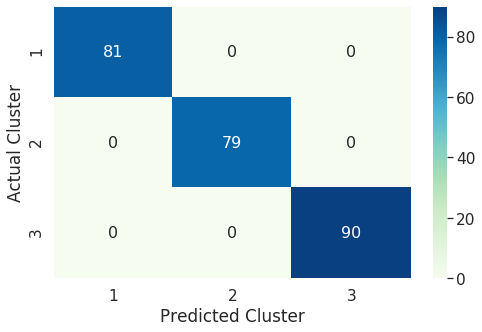

In [19]:
data = confusion_matrix(y_test, y_pred_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual Cluster'
df_cm.columns.name = 'Predicted Cluster'
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="GnBu", annot=True,annot_kws={"size": 16})
plt.show()

We can now store and deploy the pipeline for future use, but before doing this, we will complete further clustering based on customer engagement.

## CUSTOMER ENGAGEMENT MODEL

Next we will cluster our customers based on their historical energy usage and Cost-to-Serve.

### Apply Transformer and Build Model

We combine the two transformers created earlier in the notebook, during the data prep stage. We apply them to the features specified in `customer_engagement_categorical_cols` and `customer_engagement_numerical_cols` lists. In our case, since `customer_engagement_categorical_cols` is an empty list, the transformer only created missing values and scaled the features listed in the `customer_engagement_numerical_cols` list.

In [20]:
# we take a copy of df_prep for use in the segmentation
# remove the lifestyle cluster assignment column
# we'll use this dataframe towards the end of the notebook and include it as part of our segmentation pipeline deployment
# we don't use df_prep itself as additional columns get added to the dataframe later in the notebook
df_customer_engagement = df_prep.drop('LIFESTYLE_CLUSTER', axis=1).copy()

In [21]:
customer_engagement_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, customer_engagement_numerical_cols),
        ('cat', categorical_transformer, customer_engagement_categorical_cols)
            ])

customer_engagement_postprocess = customer_engagement_preprocessor.fit_transform(df_customer_engagement)

We can now begin clustering. For clustering we'll use the k-means clustering algorithm. K-means clustering simply partitions the data into k clusters where each observation belongs to the cluster with the nearest mean. When using k-means you have to specify the number of clusters beforehand, but often times that number is unknown. We'll loop through the k-means algorithm using a range of number of clusters and determine cluster number by using the silhouette coefficient metric. <br>
The silhouette coefficient indicates how similar the observations within its own cluster are compared to other observations in different clusters. Range for silhouette coefficient are from -1 to 1 where 1 represents objects within its own cluster are well paired.


In [22]:
silhouette_scores = []
for i in range(4,11):
    clf = KMeans(n_clusters=i, random_state=1234)
    cluster_assignments = clf.fit_predict(customer_engagement_postprocess)
    X=silhouette_score(customer_engagement_postprocess,cluster_assignments)
    silhouette_scores.append(X)
    print("CLUSTERS",i,"SCORE",X)

CLUSTERS 4 SCORE 0.5214481806873907
CLUSTERS 5 SCORE 0.5152787725988095
CLUSTERS 6 SCORE 0.4818742461617762
CLUSTERS 7 SCORE 0.43899381424731043
CLUSTERS 8 SCORE 0.42571012908443445
CLUSTERS 9 SCORE 0.390439306496766
CLUSTERS 10 SCORE 0.36549871782569826


From the above we see that number of clusters should be between 4 and 6 based on the silhouette coefficient. For this exercise we selected 6 clusters. 

We will create a pipeline that combines the transformer for processing the data with the final kmeans model.

In [23]:
customer_engagement_pipeline = Pipeline(steps=[('preprocessor', customer_engagement_preprocessor),
                      ('classifier', KMeans(n_clusters=6, random_state=1234))])

customer_engagement_clf = customer_engagement_pipeline.fit(df_customer_engagement)
y_clusters = customer_engagement_clf.predict(df_customer_engagement)

# Assign the clusters back into the original data - df_prep
df_prep['CUSTOMER_ENGAGEMENT'] = y_clusters
df_prep['CUSTOMER_ENGAGEMENT'] = df_prep['CUSTOMER_ENGAGEMENT'] + 1
df_prep['CUSTOMER_ENGAGEMENT'].value_counts()

5    221
6    193
2    175
1    168
4    142
3    101
Name: CUSTOMER_ENGAGEMENT, dtype: int64

### Plot Variable Distribution by Cluster

The below code loops through each numerical variable and plots the distribution of each variable by cluster.

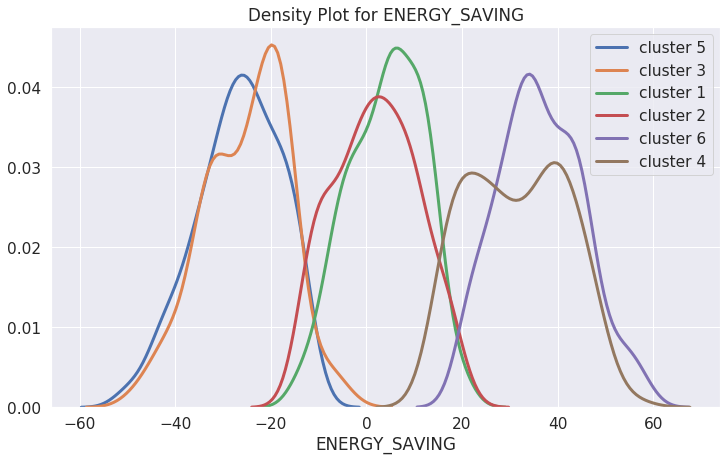

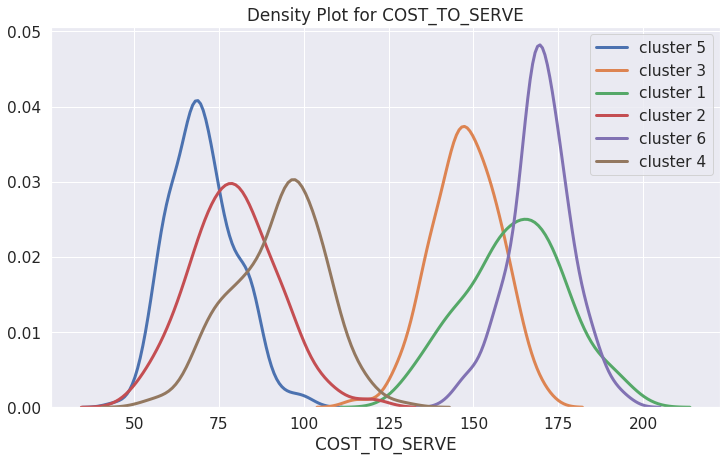

In [24]:
customer_engagement_cluster='CUSTOMER_ENGAGEMENT'
for feature in customer_engagement_numerical_cols:
    
    plot_numeric_vars(feature, df_prep,customer_engagement_cluster)

All customers are assigned to a cluster based on their energy savings and Cost-to-Serve. By looking at the above chart the 6 clusters can be explained as below: <br>

**Cluster 1:** Customers with medium energy saving, high Cost-to-Serve <br>
**Cluster 2:** Customers with medium energy saving, low Cost-to-Serve <br>
**Cluster 3:** Customers with high energy saving, medium to high Cost-to-Serve <br>
**Cluster 4:** Customers with low energy saving, low to medium Cost-to-Serve <br>
**Cluster 5:** Customers with high energy saving, low Cost-to-Serve <br>
**Cluster 6:** Customers with low energy saving, high Cost-to-Serve <br>

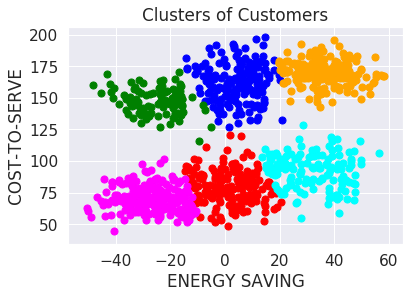

In [25]:
plt.scatter(df_prep[df_prep['CUSTOMER_ENGAGEMENT']==1]['ENERGY_SAVING'], df_prep[df_prep['CUSTOMER_ENGAGEMENT']==1]['COST_TO_SERVE'], s=50, c='blue', label ='Cluster 1')
plt.scatter(df_prep[df_prep['CUSTOMER_ENGAGEMENT']==2]['ENERGY_SAVING'], df_prep[df_prep['CUSTOMER_ENGAGEMENT']==2]['COST_TO_SERVE'], s=50, c='red', label ='Cluster 2')
plt.scatter(df_prep[df_prep['CUSTOMER_ENGAGEMENT']==3]['ENERGY_SAVING'], df_prep[df_prep['CUSTOMER_ENGAGEMENT']==3]['COST_TO_SERVE'], s=50, c='green', label ='Cluster 3')
plt.scatter(df_prep[df_prep['CUSTOMER_ENGAGEMENT']==4]['ENERGY_SAVING'], df_prep[df_prep['CUSTOMER_ENGAGEMENT']==4]['COST_TO_SERVE'], s=50, c='cyan', label ='Cluster 4')
plt.scatter(df_prep[df_prep['CUSTOMER_ENGAGEMENT']==5]['ENERGY_SAVING'], df_prep[df_prep['CUSTOMER_ENGAGEMENT']==5]['COST_TO_SERVE'], s=50, c='magenta', label ='Cluster 5')
plt.scatter(df_prep[df_prep['CUSTOMER_ENGAGEMENT']==6]['ENERGY_SAVING'], df_prep[df_prep['CUSTOMER_ENGAGEMENT']==6]['COST_TO_SERVE'], s=50, c='orange', label ='Cluster 6')
plt.title('Clusters of Customers')
plt.xlabel('ENERGY SAVING')
plt.ylabel('COST-TO-SERVE')
plt.show()

Its not necessary to build a classfier on top of Kmeans model, as we will be able to score new data using kmeans predict() method.

## Save Data for RShiny Dashboard

We save the data out for use in the RShiny dashboard. This data contains records for all customers and their respective Lifestyle and Customer Engagement Clusters.

In [26]:
# add the segment names to the dataframe
df_prep['LIFESTYLE_CLUSTER_DESCRIPTION'] = 'Green Neutral'
df_prep.loc[df_prep['LIFESTYLE_CLUSTER']==1, 'LIFESTYLE_CLUSTER_DESCRIPTION'] = 'Green Negative'
df_prep.loc[df_prep['LIFESTYLE_CLUSTER']==2, 'LIFESTYLE_CLUSTER_DESCRIPTION'] = 'Green Positive'

df_prep['CUSTOMER_ENGAGEMENT_CLUSTER_DESCRIPTION'] = 'Medium Energy Saving, High Cost-to-Serve'
df_prep.loc[df_prep['CUSTOMER_ENGAGEMENT']==2, 'CUSTOMER_ENGAGEMENT_CLUSTER_DESCRIPTION'] = 'Medium Energy Saving, Low Cost-to-Serve'
df_prep.loc[df_prep['CUSTOMER_ENGAGEMENT']==3, 'CUSTOMER_ENGAGEMENT_CLUSTER_DESCRIPTION'] = 'High Energy Saving, Medium to High Cost-to-Serve'
df_prep.loc[df_prep['CUSTOMER_ENGAGEMENT']==4, 'CUSTOMER_ENGAGEMENT_CLUSTER_DESCRIPTION'] = 'Low Energy Saving, Low to Medium Cost-to-Serve'
df_prep.loc[df_prep['CUSTOMER_ENGAGEMENT']==5, 'CUSTOMER_ENGAGEMENT_CLUSTER_DESCRIPTION'] = 'High Energy Saving, Low Cost-to-Serve'
df_prep.loc[df_prep['CUSTOMER_ENGAGEMENT']==6, 'CUSTOMER_ENGAGEMENT_CLUSTER_DESCRIPTION'] = 'Low Energy Saving, High Cost-to-Serve'

In [27]:
df_prep.head()

,CUSTOMER_ID,PROD_ECOLOGICAL,PROD_MEAT_SUBST,PROD_FAIRTRADE,PROD_REFORM,GREEN_ENERGY,FREQUENTING_NATURE,ENVIR_CHARITY,NATURE_CHARITY,AGE_GROUP,...,TOTAL_USAGE_YEAR1,TOTAL_USAGE_YEAR2,ENERGY_SAVING,COST_TO_SERVE,NUMBER_OF_QUESTIONS_ANSWERED_YES,NUMBER_OF_QUESTIONS_ANSWERED_CAT,LIFESTYLE_CLUSTER,CUSTOMER_ENGAGEMENT,LIFESTYLE_CLUSTER_DESCRIPTION,CUSTOMER_ENGAGEMENT_CLUSTER_DESCRIPTION
0,1,1,0,0,0,1,0,0,0,<20,...,5055.71,3979.551562,-21.286000,75.05,2,TWO OR THREE,3,5,Green Neutral,"High Energy Saving, Low Cost-to-Serve"
1,2,0,0,0,1,1,0,0,0,35 to 39,...,8636.82,7077.181393,-18.058019,145.17,2,TWO OR THREE,3,3,Green Neutral,"High Energy Saving, Medium to High Cost-to-Serve"
2,3,0,1,0,0,0,1,1,1,>64,...,11454.37,12733.783970,11.169658,164.59,4,FOUR OR MORE,2,1,Green Positive,"Medium Energy Saving, High Cost-to-Serve"
3,4,0,1,0,0,0,1,0,0,30 to 34,...,5668.38,5208.521333,-8.112700,144.40,2,TWO OR THREE,3,3,Green Neutral,"High Energy Saving, Medium to High Cost-to-Serve"
4,5,0,1,1,0,0,0,0,0,30 to 34,...,7499.15,9032.882231,20.452081,67.64,2,TWO OR THREE,3,2,Green Neutral,"Medium Energy Saving, Low Cost-to-Serve"


In [28]:
# save the data using the project_lib library
project.save_data('model output summary.csv', df_prep.to_csv(index=False), overwrite=True)

{'file_name': 'data_asset/model output summary.csv',
 'message': 'File saved to project storage.',
 'asset_id': 'b694d4c4-8d27-489a-8ebb-d0cb76b5f936'}

## Save the Pipelines to Cloud Pak for Data

In the next steps we save and deploy the pipelines we created in the notebook. The pipeline can be saved and deployed in the same way we save and deploy models.

Before we save the pipeline, we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space.

The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the watson_machine_learning_client package to complete these steps.

### User Inputs

The user can specify the name for the space, models and model deployments.

In [29]:
# Specify a name for the space being created. 
space_name = 'Utilities Customer Micro-Segmentation Space'

lifestyle_model_name = 'lifestyle_pipeline'
customer_engagement_model_name = 'customer_engagement_pipeline'

lifestyle_deployment_name = 'lifestyle_pipeline_deployment'
customer_engagement_deployment_name = 'customer_engagement_pipeline_deployment'

In [30]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "3.0.0"
}

client = WatsonMachineLearningAPIClient(wml_credentials)

### Create the Deployment Space

Create a new deployment space. Use the name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space. If a space with specified space_name already exists, a new space with the same name is created. Set this deployment space as the default space.

In [31]:
# create the space and set it as default
space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name,
        client.spaces.ConfigurationMetaNames.TAGS : [{'value':'Utilities Customer Micro-Segmentation space tag'}]
}

stored_space_details = client.spaces.store(space_meta_data)

space_uid = stored_space_details['metadata']['guid']

client.set.default_space(space_uid)

'SUCCESS'

### Store the Lifestyle Pipeline and Deploy

Store the Lifestyle pipeline in the deployment space. The name for the pipeline is specified in the user inputs cell above. A default tag for the pipeline is specified in the model metadata. Although we use a pipeline, we save it in the same way we would save a model.

In [32]:
metadata = {
    client.repository.ModelMetaNames.NAME: lifestyle_model_name,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.22",
    client.repository.ModelMetaNames.RUNTIME_UID: "scikit-learn_0.22-py3.6",
    client.repository.ModelMetaNames.TAGS: [{'value' : 'utilities_lifestyle_pipeline_tag'}],
    client.repository.ModelMetaNames.SPACE_UID: space_uid
}
    
# include the training data and column names used for building the model
# these are required when scoring new data using a pipeline
stored_model_details = client.repository.store_model(model=lifestyle_clf, meta_props=metadata, training_data=X_train, training_target=y_train,
                                                     feature_names=X_train.columns)

Next we deploy the stored model. A default tag for the deployment is specified in the deployment metadata. This tag will be used in the future to identify this deployment.

We also include the dictionary with the inputs specified by the user as part of the deployment. It gets deployed with the pipeline and can be retrieved in a deployed function, as demonstrated in the 2-model_scoring_and_app_deployment notebook.

In [33]:
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: lifestyle_deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : [{'value' : 'utilities_lifestyle_pipeline_deployment_tag'}],
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.CUSTOM: user_inputs_dict
}

# deploy the pipeline
model_uid = stored_model_details["metadata"]["guid"]
deployment_details = client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: 'be9994bf-9687-40dc-a02c-6e756ad6d3ef' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='1192761d-5676-4e47-9fc1-1662b5b8a004'
------------------------------------------------------------------------------------------------




### Store the Customer Engagement Pipeline and Deploy

We repeat the same steps as above for storing and deploying the Customer Engagement pipeline in the deployment space. Again, we use the names specified in the user inputs cell and use default tags in the metadata. 

In [34]:
metadata = {
    client.repository.ModelMetaNames.NAME: customer_engagement_model_name,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.22",
    client.repository.ModelMetaNames.RUNTIME_UID: "scikit-learn_0.22-py3.6",
    client.repository.ModelMetaNames.TAGS: [{'value' : 'utilities_customer_engagement_pipeline_tag'}],
    client.repository.ModelMetaNames.SPACE_UID: space_uid
}
    
# include the data used for building the model as is required when scoring new data using a pipeline
# although we are clustering and don't have any target variable, a target must be included when storing the model, it is not used 
stored_model_details = client.repository.store_model(model=customer_engagement_clf, meta_props=metadata, training_data=df_customer_engagement, training_target=np.zeros(df_customer_engagement.shape[0]),
                                                     feature_names=df_customer_engagement.columns)

In [35]:
# deploy the model
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: customer_engagement_deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : [{'value' : 'utilities_customer_engagement_pipeline_deployment_tag'}],
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.CUSTOM: user_inputs_dict
}

# deploy the pipeline
model_uid = stored_model_details["metadata"]["guid"]
deployment_details = client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: '528ac05a-e865-4391-8441-74c037457546' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='d3731e41-b4fe-4e08-a7d7-6482a7456b30'
------------------------------------------------------------------------------------------------




## Operationalize the models

Now we are ready to operationalize our pipeline. See notebook 2-model_scoring_and_app_deployment for the next step.